install all the packages:

In [1]:
import pandas as pd
import numpy as np
from adtoolbox import core,configs,utils,adm
import plotly.express as px

In [2]:
acids=pd.read_table('../raw_data/DeLong_beto/acids_cleaned.csv',delimiter=',')
metadata=pd.read_table("../raw_data/DeLong_beto/DeLong_metadata_final[72].txt", delimiter="\t")

Filter/delete duplicates on the acid column

In [3]:
acids2adm={
    "C4":"S_bu",
    "C3":"S_pro",
    "C5":"S_va",
    "ISOC5":"S_va",
    "ISOC4":"S_bu",
    "C2":"S_ac",
    "C6":"S_cap",
    "ISOC6":"S_cap"

}

In [4]:
def identifier(items):
    if items in acids2adm:
        return acids2adm[items]

acids["admids"]=acids["acid"].apply(identifier)

In [5]:
acids2seed={
    "C4":"cpd00211",
    "C3":"cpd00141",
    "C5":"cpd00597",
    "ISOC5":"cpd00597",
    "ISOC4":"cpd00211",
    "C2":"cpd00029",
    "C6":"cpd01113",
    "ISOC6":"cpd01113"

}

In [6]:
def identity(items):
    if items in acids2seed:
        return acids2seed[items]

acids["seedids"]=acids["acid"].apply(identity)

We have to make sure we have Seed databases downloaded for COD calculations

In [7]:
from adtoolbox import core,configs
seed_db=core.SeedDB(configs.Database())
db=core.Database(configs.Database())
# db.download_seed_databases()

In [8]:
acids=acids.dropna()

In [9]:
codmap={ i:seed_db.instantiate_metabs(i).cod_calc(add_h=1) for i in acids["seedids"].unique()}

In [10]:
acids["cod_map"]=acids["seedids"].apply(lambda x:codmap[x])

In [11]:
acids['cod_conc']=acids['conc_gL']*acids['cod_map']

In [12]:
acids["shortsampleid"]=(acids.sample_id.str.split('_').apply(lambda x:"_".join(x[:5])))


We don't want to simulate for Control and inoculum only samples

In [13]:
pivot_df = acids.pivot_table(index=["shortsampleid", "day"], columns="acid", values="cod_conc", fill_value=0)
pivot_df["C4"]=pivot_df["C4"]+pivot_df["ISOC4"]
pivot_df["C5"]=pivot_df["C5"]+pivot_df["ISOC5"]
pivot_df["C6"]=pivot_df["C6"]+pivot_df["ISOC6"]
pivot_df=pivot_df.drop(columns=["ISOC4","ISOC5","ISOC6"])
pivot_df.rename(columns={"C4":"S_bu","C3":"S_pro","C5":"S_va","C2":"S_ac","C6":"S_cap"},inplace=True)
data_dict = {}
for reactor in pivot_df.index.levels[0]:
  data_dict[reactor] = {}
  data_dict[reactor]["time"]=pivot_df.loc[reactor].index.tolist()
  data_dict[reactor]["data"]=pivot_df.loc[reactor].to_dict(orient="list")


In [14]:
cod_counts=pd.read_csv('./COD_counts.csv')

In [15]:
data_i={}
for i in cod_counts.columns[cod_counts.columns.str.endswith("_D0")]:
  data_i[i]=cod_counts.set_index("Unnamed: 0")[i].to_dict()



In [16]:
num_failed=0
pivot_df = acids.pivot_table(index=["shortsampleid", "day"], columns="acid", values="cod_conc", fill_value=0)
pivot_df["C4"]=pivot_df["C4"]+pivot_df["ISOC4"]
pivot_df["C5"]=pivot_df["C5"]+pivot_df["ISOC5"]
pivot_df["C6"]=pivot_df["C6"]+pivot_df["ISOC6"]
pivot_df=pivot_df.drop(columns=["ISOC4","ISOC5","ISOC6"])
pivot_df.rename(columns={"C4":"S_bu","C3":"S_pro","C5":"S_va","C2":"S_ac","C6":"S_cap"},inplace=True)
data_dict = {}
for reactor in pivot_df.index.levels[0]:
  data_dict[reactor] = {}
  data_dict[reactor]["time"]=pivot_df.loc[reactor].index.tolist()
  data_dict[reactor]["data"]=pivot_df.loc[reactor].to_dict(orient="list")

  try:
    data_dict[reactor]["Initial conditions"]=cod_counts.set_index("Unnamed: 0")[reactor+"_D0"].to_dict()
  except:
    num_failed+=1
    print("Failure: ",num_failed,":",reactor)
      

Failure:  1 : A_35_F_5_B
Failure:  2 : A_35_F_5_D
Failure:  3 : A_35_F_5_INOC
Failure:  4 : A_35_F_7_D
Failure:  5 : A_35_F_7_INOC
Failure:  6 : A_35_F_9_D
Failure:  7 : A_35_F_9_INOC
Failure:  8 : A_35_M_5_A
Failure:  9 : A_35_M_5_D
Failure:  10 : A_35_M_5_INOC
Failure:  11 : A_35_M_7_B
Failure:  12 : A_35_M_7_C
Failure:  13 : A_35_M_7_D
Failure:  14 : A_35_M_9_D
Failure:  15 : A_35_M_9_INOC
Failure:  16 : A_45_F_5_A
Failure:  17 : A_45_F_5_B
Failure:  18 : A_45_F_5_C
Failure:  19 : A_45_F_5_D
Failure:  20 : A_45_F_5_INOC
Failure:  21 : A_45_F_7_D
Failure:  22 : A_45_F_7_INOC
Failure:  23 : A_45_F_9_D
Failure:  24 : A_45_F_9_INOC
Failure:  25 : A_45_M_5_A
Failure:  26 : A_45_M_5_B
Failure:  27 : A_45_M_5_D
Failure:  28 : A_45_M_5_INOC
Failure:  29 : A_45_M_7_D
Failure:  30 : A_45_M_9_A
Failure:  31 : A_45_M_9_B
Failure:  32 : A_45_M_9_C
Failure:  33 : A_45_M_9_D
Failure:  34 : B_35_F_5_D
Failure:  35 : B_35_F_9_D
Failure:  36 : B_35_M_5_D
Failure:  37 : B_35_M_7_D
Failure:  38 : B_35_

In [17]:
feed_manure = metadata[metadata['feedstock']==('M')]

In [18]:
feed_manure=feed_manure['feedstock']

In [19]:
feed_waste = metadata[metadata['feedstock']==('F')]

In [20]:
feed_waste=feed_waste['feedstock']

In [21]:
manure = core.Feed(
        name="Manure",
        lipids=10.7,
        proteins=17.3,
        carbohydrates=70,
        xi= 60,
        si=50,
        tss=80,
)

In [22]:
foodwaste = core.Feed(
        name="foodwaste",
        lipids=21,
        proteins=20.5,
        carbohydrates=50.1,
        xi=60,
        si=50,
        tss=65
)

In [23]:
core.Database(configs.Database(
    adm_parameters_urls=configs.E_ADM_2_REMOTE,
    adm_parameters=configs.E_ADM_2_LOCAL
)).download_adm_parameters()


model_parameters downloaded to /Users/parsaghadermarzi/Desktop/ADToolbox/Database/ADM_Paramet
ers/e_adm_2_model_parameters.json

base_parameters downloaded to /Users/parsaghadermarzi/Desktop/ADToolbox/Database/ADM_Paramete
rs/e_adm_2_base_parameters.json

initial_conditions downloaded to /Users/parsaghadermarzi/Desktop/ADToolbox/Database/ADM_Param
eters/e_adm_2_initial_conditions.json

inlet_conditions downloaded to /Users/parsaghadermarzi/Desktop/ADToolbox/Database/ADM_Paramet
ers/e_adm_2_inlet_conditions.json

reactions downloaded to 
/Users/parsaghadermarzi/Desktop/ADToolbox/Database/ADM_Parameters/e_adm_2_reactions.json

species downloaded to 
/Users/parsaghadermarzi/Desktop/ADToolbox/Database/ADM_Parameters/e_adm_2_species.json

In [24]:
params=utils.load_multiple_json_files(configs.E_ADM_2_LOCAL)

We need a definition of the feedstock

In [25]:
Manure = core.Feed(
        name="Manure",
        lipids=10.7,
        proteins=30,
        carbohydrates=59.3,
        xi= 80,
        si=50,
        tss=95,
 )
foodwaste = core.Feed(
        name="foodwaste",
        lipids=21,
        proteins=20.5,
        carbohydrates=50.1,
        xi=60,
        si=50,
        tss=65
)

In [26]:
results_dict = {}
# dash_apps = {}
inoculum_cod=10
total_feed_cod=15
params.base_parameters['q_in'] = 0
mgo=core.Database(config=configs.Database())
for reactor_name, reactor_data in data_dict.items():
    if "Initial conditions" in reactor_data:
        initial_conditions = {key:value*inoculum_cod for key,value in reactor_data["Initial conditions"].items()}
        initial_conditions["X_VFA_deg"]=0.1*inoculum_cod
        _, t, f, ph, _ = reactor_name.split("_")
        print(float(t), f, float(ph),end="\r")
        if f == "F":
            feed = foodwaste
        else:
            feed = Manure
        initial_conditions["TSS"]=total_feed_cod*feed.tss/100
        initial_conditions["TDS"]=total_feed_cod-initial_conditions["TSS"]
        initial_conditions["S_su"]=0
        initial_conditions["S_aa"]=0
        initial_conditions["S_va"]=0
        initial_conditions["S_fa"]=0
        initial_conditions["S_ac"]=0
        initial_conditions["S_cap"]=0
        if reactor_data["time"][0] != 0:
            reactor_data["time"].insert(0,0)
            for key in reactor_data["data"]:
                reactor_data["data"][key].insert(0,0)
        
        for key,value in reactor_data["data"].items():
            initial_conditions[key]=value[0]
        

        params.initial_conditions.update(initial_conditions)
        params.initial_conditions.update({"S_H_ion":10**-(float(ph))})
        params.base_parameters.update({"q_in":0,"T_op":273.15+float(t),"V_gas":0.0001,"V_liq":0.00025}),
        
        
        temp_exp_obj=core.Experiment(
            name=reactor_name+"_Delong_BETO",
            time=reactor_data["time"],
            variables=list(reactor_data["data"].keys()),
            data=list(reactor_data["data"].values()),
            initial_concentrations=params.initial_conditions,
            base_parameters=params.base_parameters,
            constants=["S_H_ion"],
            reference="Delong_Lab_BETO_Experiment",
            model_name="e_adm_2"
        )
        
        mgo.add_experiment_to_experiments_db(temp_exp_obj,force=True)

        model = adm.Model(
            model_parameters=params.model_parameters,
            base_parameters=params.base_parameters,
            initial_conditions=params.initial_conditions,
            inlet_conditions=params.inlet_conditions,
            species=params.species,
            reactions=params.reactions,
            feed=feed,
            ode_system=adm.e_adm_2_ode_sys,
            build_stoichiometric_matrix=adm.build_e_adm_2_stoichiometric_matrix,
            time_limit=100000,
            control_state={'S_H_ion': 10 ** -(float(ph))})

        sol = model.solve_model(np.linspace(0, 20, 10))
        results_dict[reactor_name] = pd.DataFrame(sol.y.T,columns=params.species)



In [27]:
only_initial_conditions = {}
for data, initial in data_dict.items():
    if "Initial conditions" in initial:
        only_initial_conditions[data] = pd.DataFrame(initial["data"]).max()

In [28]:
exp_data_sim=pd.DataFrame(only_initial_conditions).T

In [29]:
exp_data_sim["Feed"]=exp_data_sim.index.map(lambda x:x.split("_")[2])

In [30]:
exp_data_sim["PH"]=exp_data_sim.index.map(lambda x:x.split("_")[3])

In [31]:
fig=px.box(exp_data_sim,x="Feed",y="S_bu",facet_col="PH",color="Feed",points="all")
fig.update_layout(title="Butyric Acid Concentration Experimental Data")
fig.write_html("Butyric Acid Concentratio Experimental Data.html")
fig.show()

In [32]:
observed_acids=exp_data_sim.columns[:-2].to_list()
for reactor in results_dict:
  results_dict[reactor]=results_dict[reactor][observed_acids].max()


In [33]:
simulations_vfa_results=pd.DataFrame(results_dict).T

In [34]:
simulations_vfa_results["Feed"]=simulations_vfa_results.index.map(lambda x:x.split("_")[2])

In [35]:
simulations_vfa_results["PH"]=simulations_vfa_results.index.map(lambda x:x.split("_")[3])

In [36]:
simulations_vfa_results

,S_ac,S_pro,S_bu,S_va,S_cap,Feed,PH
A_35_F_5_A,1.330069,2.745784,1.143925,2.397723,0.188390,F,5
A_35_F_5_C,1.344988,2.750399,1.157110,2.407190,0.189162,F,5
A_35_F_7_A,1.417663,2.726856,1.063152,2.441005,0.179991,F,7
A_35_F_7_B,1.500008,2.721807,1.139305,2.568534,0.189580,F,7
A_35_F_7_C,1.496114,2.714351,1.141380,2.608507,0.192300,F,7
...,...,...,...,...,...,...,...
T_55_M_7_A,0.869652,1.391867,0.598064,1.387335,0.099254,M,7
T_55_M_7_B,0.789804,1.371446,0.549078,1.394117,0.099403,M,7
T_55_M_7_C,0.737195,1.371587,0.515765,1.414762,0.100985,M,7
T_55_M_9_B,1.530275,0.873428,0.197922,1.961310,0.122907,M,9


In [37]:
fig=px.box(simulations_vfa_results,x="Feed",y="S_bu",facet_col="PH",color="Feed",points="all")
fig.update_layout(title="Simulated Butyric Acid concentrations")
fig.write_html("simulated_vfa_concentrations.html")
fig.show()

In [38]:
from adtoolbox import optimize
from importlib import reload

In [39]:
exp=core.Database(configs.Database()).get_experiment_from_experiments_db(field_name="name",query="")

In [40]:
model.sim_time=30

In [43]:
exp

[Experiment(name='fw_twas_rep_1', time=[0, 1, 5, 11, 18, 24], variables=[9, 5, 4, 3, 8], data=array([[2.42133333e-02, 4.55567568e-03, 3.14181818e-02, 4.09882353e-03,
         0.00000000e+00],
        [4.02826667e-01, 5.89816216e-01, 1.43163636e-01, 8.43827451e-02,
         1.59558621e-02],
        [1.96010667e+00, 1.68461622e+00, 1.65812727e+00, 1.87077647e+00,
         1.82201379e-01],
        [2.56615467e+00, 2.21682811e+00, 2.13754545e+00, 3.15362667e+00,
         2.34217931e-01],
        [9.51893333e-02, 2.62659676e+00, 2.42809091e+00, 4.09965961e+00,
         2.71470345e-01],
        [4.68896000e-01, 2.68592649e+00, 1.94750909e+00, 4.22547922e+00,
         2.75906207e-01]]), initial_concentrations={'S_su': 0, 'S_aa': 0, 'S_fa': 0, 'S_va': 0.001, 'S_bu': 0.001, 'S_et': 0.0, 'S_lac': 0.0, 'S_pro': 0.001, 'S_cap': 0.0, 'TSS': 5.4, 'TDS': 12.6, 'S_ac': 0.001, 'X_chain_lac': 0.25736217483886864, 'S_h2': 1e-08, 'S_ch4': 1e-05, 'S_IC': 0.04, 'S_IN': 0.01, 'S_I': 0.02, 'X_ac_et': 0.205017

In [42]:
optimize.validate_model(model=model,data=,plot=True,show_extra_states=["S_H_ion"])

ValueError: 9 is not in list

In [44]:
tunables={
          "f_pro_su": (0.2,0.45), 
          "f_et_su": (0.01,0.3), 
          "f_lac_su": (0.1,0.3), 
          "K_pH_ac":(0.001,0.1),
          "Y_su": (0.01,0.3), 
          "K_S_su": (1,10),
          "K_S_ac": (1,10),
          "K_S_pro": (1,10),
          "K_I_h2_ox": (1e-8,1000),
          "K_I_h2_c4": (1e-8,10),
          "K_I_h2_pro": (1e-8,100),
          "K_I_h2_fa":(1e-8,10),
          "f_co2_ch4":(-1,-0.000001),
          "K_S_IN": (1e-5,10),
          "f_pro_aa": (0.1,0.7),
          "f_et_aa": (0.0001,0.2),
          "f_lac_aa": (0.01,0.3),
          "Y_ac_et": (0.01,0.2),  
          "f_et_ac": (-0.3,-0.15),
          "f_bu_ac": (0.6,1), 
          "Y_ac_lac": (0.1,0.4), 
          "f_lac_ac": (-0.3,-0.01),
          "f_h2_ac": (0.1,0.2),
          "Y_ac_et_ox":(0.1,0.3), 
          "Y_pro_lac_ox": (0.01,0.3), 
          "Y_pro_et": (0.01,0.3),  
          "f_et_pro": (-1,-0.15), 
          "f_va_pro": (0.8,1), 
          "Y_pro_lac": (0.01,0.3),
          "f_lac_pro": (-0.5,-0.15),
          "f_h2_pro": (0.01,0.2), 
          "Y_chain_et_pro": (0.01,0.3),  
          "Y_chain_lac_pro": (0.01,0.3),  
          "Y_bu_et": (0.01,0.3),  
          "f_et_bu": (-1,-0.1), 
          "f_cap_bu": (0.6,1),
          "Y_bu_lac": (0.1,0.8), 
          "f_lac_bu": (-1,-0.1), 
          "f_h2_bu": (0.01,0.2), 
          "Y_va": (0.1,0.3), 
          "Y_cap": (0.2,0.6),
          "Y_h2_ac": (0.1,0.3),
          "Y_h2_CO2": (0.1,0.3), 
          "f_ac_h2": (-1,-0.5),
          "Y_Me_ac": (0.1,0.3), 
          "Y_Me_CO2": (0.1,0.3), 
          "Y_Me_h2": (0.1,0.3), 
          "Y_aa": (0.01,0.3),
          "Y_fa": (0.01,0.3),
          "Y_ac": (0.01,0.5), 
          "k_dis_TSS": (0.01,0.5), 
          "k_dis_TDS": (0.1,10), 
          "k_hyd_ch": (0.01,15), 
          "k_hyd_pr": (0.01,15), 
          "k_hyd_li": (0.11,15), 
          "k_m_su": (1,50), 
          "K_S_su": (1,40), 
          "k_m_aa": (1,35), 
          "K_S_aa": (0.1,40), 
          "k_m_fa": (0.1,30), 
          "K_S_fa": (0.1,20), 
          "k_m_bu": (0.5,20), 
          "K_S_bu": (0.05,50), 
          "k_m_va": (0.1,2),  
          "K_S_va": (0.01,20),
          "k_m_cap": (0.01,5),
          "K_S_cap": (0.01,50),
          "k_m_pro": (1,40), 
          "K_S_pro": (0.01,20),
          "k_m_et": (1,50),
          "K_S_et": (1,150), 
          "k_m_lac": (0.1,30), 
          "K_S_lac": (0.01,100),
          "k_m_ac": (10,50), 
          "K_S_ac": (0.01,15),  
          "k_m_h2_Me_ac": (1,100), 
          "K_S_h2_Me_ac": (1e-06,1e-02),
          "K_S_ac_Me": (0.001,20),
          "k_m_h2_Me_CO2": (0.1,50), 
          "K_S_h2_Me_CO2": (1e-06,1e-02),
          "K_S_CO2_Me": (0.01,5),  
          "f_pro_fa": (0.2,0.6),
          "f_et_fa": (0,0.1),
          "f_lac_fa":(0,0.1),
          "k_L_a":(10,100),
          "K_S_ac_lac":(0.01,50),
          "K_S_ac_et":(0.01,10),
          "K_S_pro_et":(0.01,0.6),
          "K_S_bu_et":(0.01,0.6),
          "K_S_bu_lac":(0.01,0.6),
          "K_S_pro_lac": (0.01,0.6),
          'f_ac_h2':(-0.2,-0.01),
          "k_m_bu_deg":(0.1,10),
          "Y_bu":(0.01,10),
          "K_pH_aa":(0.0000001,10),
          "nn_aa":(0.1,10),
          'K_pH_ac':(0.0000001,10),
          'n_ac':(0.1,10),
          'K_pH_pro':(0.000001,10),
          'n_pro':(0.1,10),
          "K_pH_bu":(0.0000001,10),
          'n_bu':(0.1,50),    
          "K_pH_va":(0.0000001,10),
          'n_va':(0.1,10),    
          "K_pH_cap":(0.000001,10),
          'n_cap':(0.1,10),                 
 }

In [45]:
model.time_limit=100
optimizer = optimize.NNSurrogateTuner(
    base_model=model,
    train_data=exp[6:],
    tuneables=tunables,
    initial_points=5,)

In [46]:
optimizer.optimize(perturbation_method="estimate_gradient_directions",ode_method="BDF")

Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value


/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1720: RuntimeWarning:

overflow encountered in double_scalars

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1758: RuntimeWarning:

invalid value encountered in matmul

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1714: RuntimeWarning:

overflow encountered in double_scalars

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1723: RuntimeWarning:

overflow encountered in double_scalars

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1726: RuntimeWarning:

overflow encountered in double_scalars



Could not solve model, setting C to a very large value
Training Loss: 569451.25
Step 1/100 completed.Current cost:576.0881329514324 Best cost: 576.0881329514324
Training Loss: 481446.71875
Step 2/100 completed.Current cost:576.0881329514324 Best cost: 576.0881329514324
Training Loss: 411280.84375
Local optima reached: Perturbing the best solution and continuing.
Step 3/100 completed.Current cost:590.9393730963704 Best cost: 576.0881329514324
Training Loss: 354667.6875
Step 4/100 completed.Current cost:576.0881329514324 Best cost: 576.0881329514324
Training Loss: 304608.65625
Step 5/100 completed.Current cost:576.0881329514324 Best cost: 576.0881329514324
Training Loss: 261153.046875
Local optima reached: Perturbing the best solution and continuing.
Step 6/100 completed.Current cost:588.3878128564796 Best cost: 576.0881329514324
Training Loss: 223827.203125
Step 7/100 completed.Current cost:576.0881329514324 Best cost: 576.0881329514324
Training Loss: 190018.453125
Step 8/100 completed.

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1717: RuntimeWarning:

overflow encountered in double_scalars

/Users/parsaghadermarzi/Desktop/Academics/Projects/ADToolbox/adtoolbox/adm.py:1729: RuntimeWarning:

overflow encountered in double_scalars



Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Could not solve model, setting C to a very large value
Step 12/100 completed.Current cost:1.6999999998506293e+22 Best cost: 576.0881329514324
Training Loss: 93189.65625
Step 13/100 completed.Current cost:576.0881329514324 Best cost: 576.0881329514324
Training Loss: 75162.7578125
Step 14/100 completed.Current cost:576.0881329514324 Best cost: 576.0881329514324
Training Loss: 59890.2265625
Local optima reached: Perturbing the best solution and continuing.
Step 15/100 completed.Current cost:559.3816598650619 Best cost: 559.3816598650619
Training Loss: 47101.5390625


KeyboardInterrupt: 

In [ ]:
import pickle

In [ ]:
with open("./history.pkl","rb") as f:
    params=pickle.load(f)

In [ ]:
min_index=params["cost"].index(min(params["cost"]))
model.update_parameters(model_parameters=dict(zip(tunables.keys(),params["parameters"][min_index])))

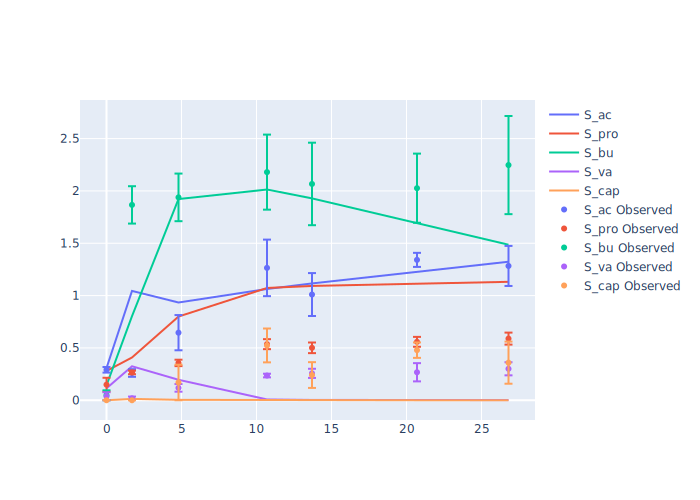

({'model':           S_ac     S_pro      S_bu      S_va     S_cap
  0.0   0.307648  0.280261  0.142472  0.114110  0.000000
  1.7   1.044527  0.408528  0.803383  0.324552  0.012908
  4.8   0.933922  0.799776  1.922303  0.195459  0.004044
  10.7  1.063109  1.072778  2.013428  0.007434  0.000162
  13.7  1.116155  1.092212  1.928606  0.003060  0.000096
  20.7  1.229080  1.116163  1.695658  0.001984  0.000071
  26.8  1.323522  1.131630  1.485957  0.001835  0.000066},
 Figure({
     'data': [{'line': {'color': '#636EFA'},
               'mode': 'lines',
               'name': 'S_ac',
               'type': 'scatter',
               'x': array([ 0. ,  1.7,  4.8, 10.7, 13.7, 20.7, 26.8]),
               'y': array([0.30764788, 1.04452742, 0.93392231, 1.06310939, 1.11615481, 1.22907987,
                           1.32352243])},
              {'line': {'color': '#EF553B'},
               'mode': 'lines',
               'name': 'S_pro',
               'type': 'scatter',
               'x': array(

In [ ]:
optimize.validate_model(model=model,data=exp,plot=True)